In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


# Carga de datos

In [101]:
df = pd.read_csv("/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt", sep = ";", low_memory = False)

In [102]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.00
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.00
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.00
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.00
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.00


# EDA

In [103]:
df.shape

(2075259, 9)

La fuente de datos cuenta con 2.075.259 registros y 9 columnas.

## Tipos de datos

In [104]:
df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

Se observa que la mayoria de columnas están en formato texto. Se debe realizar el respectivo ajuste del formato de variables.

In [105]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.drop(columns=['Date', 'Time'], inplace=True)

numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [106]:
df.dtypes

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Datetime                 datetime64[ns]
dtype: object

## Valores nulos

In [107]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Datetime                     0
dtype: int64

Se observa la presencia de multiples valores vacios. En consecuencia, se hace necesario un tratamiento para este tipo de datos. Teniendo en cuenta que se trata de una serie de tiempo, no se considera que sea viable eliminar estos registros. En consecuencia, y buscando una optimización de computo (pues siempre se tiene una amplia cantidad de registros), se aplicara una imputacion de estos valores por alguna medida de tendencia central

In [108]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.select_dtypes(include = ['number']).describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2049280.00,2049280.00,2049280.00,2049280.00,2049280.00,2049280.00,2049280.00
mean,1.09,0.12,240.84,4.63,1.12,1.30,6.46
std,1.06,0.11,3.24,4.44,6.15,5.82,8.44
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00
25%,0.31,0.05,238.99,1.40,0.00,0.00,0.00
50%,0.60,0.10,241.01,2.60,0.00,0.00,1.00
75%,1.53,0.19,242.89,6.40,0.00,1.00,17.00
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00


La tabla muestra las estadísticas descriptivas de las variables numéricas del DataFrame. Hay 2,049,280 observaciones en todas las columnas. La potencia activa global (Global_active_power) tiene una media de 1.09, una desviación estándar de 1.06, con valores que van desde 0.08 hasta 11.12. La potencia reactiva global (Global_reactive_power) tiene una media de 0.12, con un valor máximo de 1.39. El voltaje (Voltage) tiene un promedio de 240.84 y una desviación estándar de 3.24, lo que indica poca variación. La intensidad global (Global_intensity) tiene una media de 4.63 y un máximo de 48.40, sugiriendo algunos picos. Las submediciones de consumo (Sub_metering_1, Sub_metering_2, Sub_metering_3) tienen medias bajas de 1.12, 1.30 y 6.46 respectivamente, con valores máximos de 88.00, 80.00 y 31.00, indicando que generalmente los valores están en el rango bajo. Las métricas de cuartiles (25%, 50%, 75%) y los valores mínimos y máximos ayudan a entender la dispersión y distribución de cada variable.

__Por otro lado, si bien en algunas variables el rango es relativamente pequeño, en otras este llega a ser muy amplio. Por lo tanto, se descarta utilizar el promedio como medida de imputación, y se procede a hacer uso de la mediana.__

In [109]:
df = df.fillna(df.median())

In [110]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
dtype: int64

Despues de la imputación, se comprueba que ya no hay presencia de valores nulos.

## Registros duplicados

In [111]:
df.duplicated().sum()

0

Se descarta la presencia de registros duplicados.

## Detección de outliers

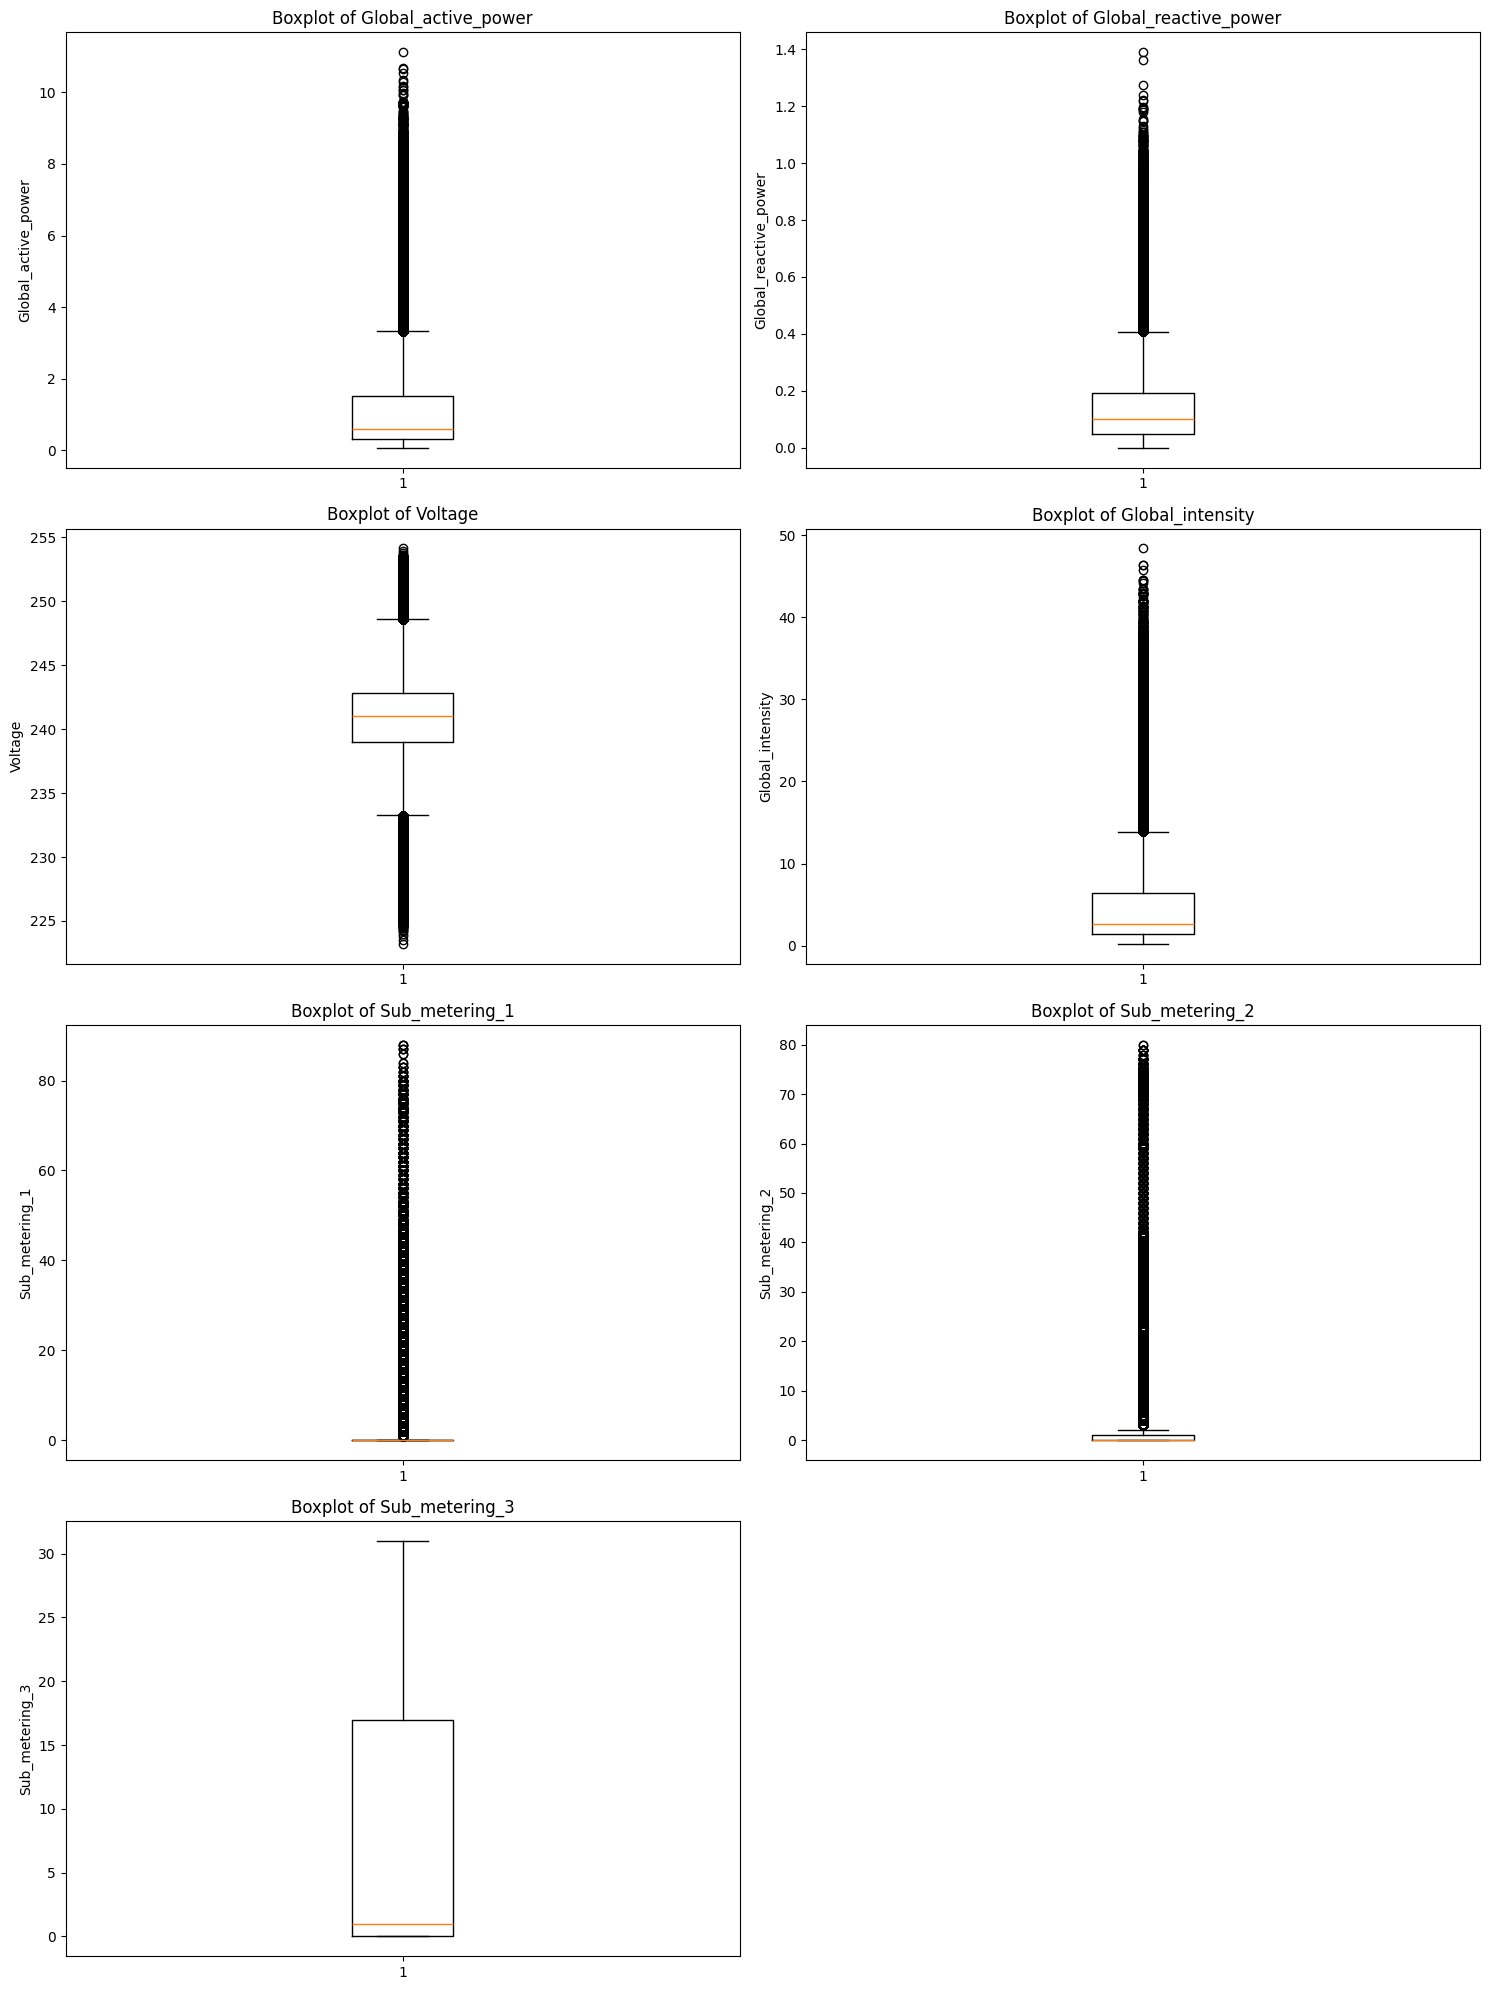

In [112]:

fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.ravel()

for i, col in enumerate(df.select_dtypes(include=['number']).columns):
    axs[i].boxplot(df.select_dtypes(include=['number'])[col].dropna())
    axs[i].set_title(f'Boxplot of {col}')
    axs[i].set_ylabel(col)

if len(df.select_dtypes(include=['number']).columns) < len(axs):
    for j in range(len(df.select_dtypes(include=['number']).columns), len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Graficamente se observa la presencia de valores atipicos en todas las variables a excepcion de Sub_metering_3. Voltage es la unica variable que muestra valores atipicos por la cola derecha e izquierda de la distribución.

In [113]:
def find_outliers_iqr(df):
    outliers = pd.DataFrame()
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outliers

outliers_iqr = find_outliers_iqr(df)
outliers_iqr.sum()

Global_active_power       96742
Global_reactive_power     42234
Voltage                   54737
Global_intensity         100961
Sub_metering_1           169105
Sub_metering_2            77151
Sub_metering_3                0
dtype: int64

Cuantificando los outliers del dataset, se muestra como 6 de 7 variables tienen más de 10000 datos atipicos. En consecuencia, se hace necesario un tratamiento para estos datos. A continuación, se aplica winsorización para ajustar los outliers.

In [114]:
def winsorize_series(series, lower_percentile=0.05, upper_percentile=0.95):
    lower_bound = series.quantile(lower_percentile)
    upper_bound = series.quantile(upper_percentile)
    return series.clip(lower=lower_bound, upper=upper_bound)

def winsorize_dataframe(df, lower_percentile=0.05, upper_percentile=0.95):
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        df[col] = winsorize_series(df[col], lower_percentile, upper_percentile)
    return df

df = winsorize_dataframe(df)

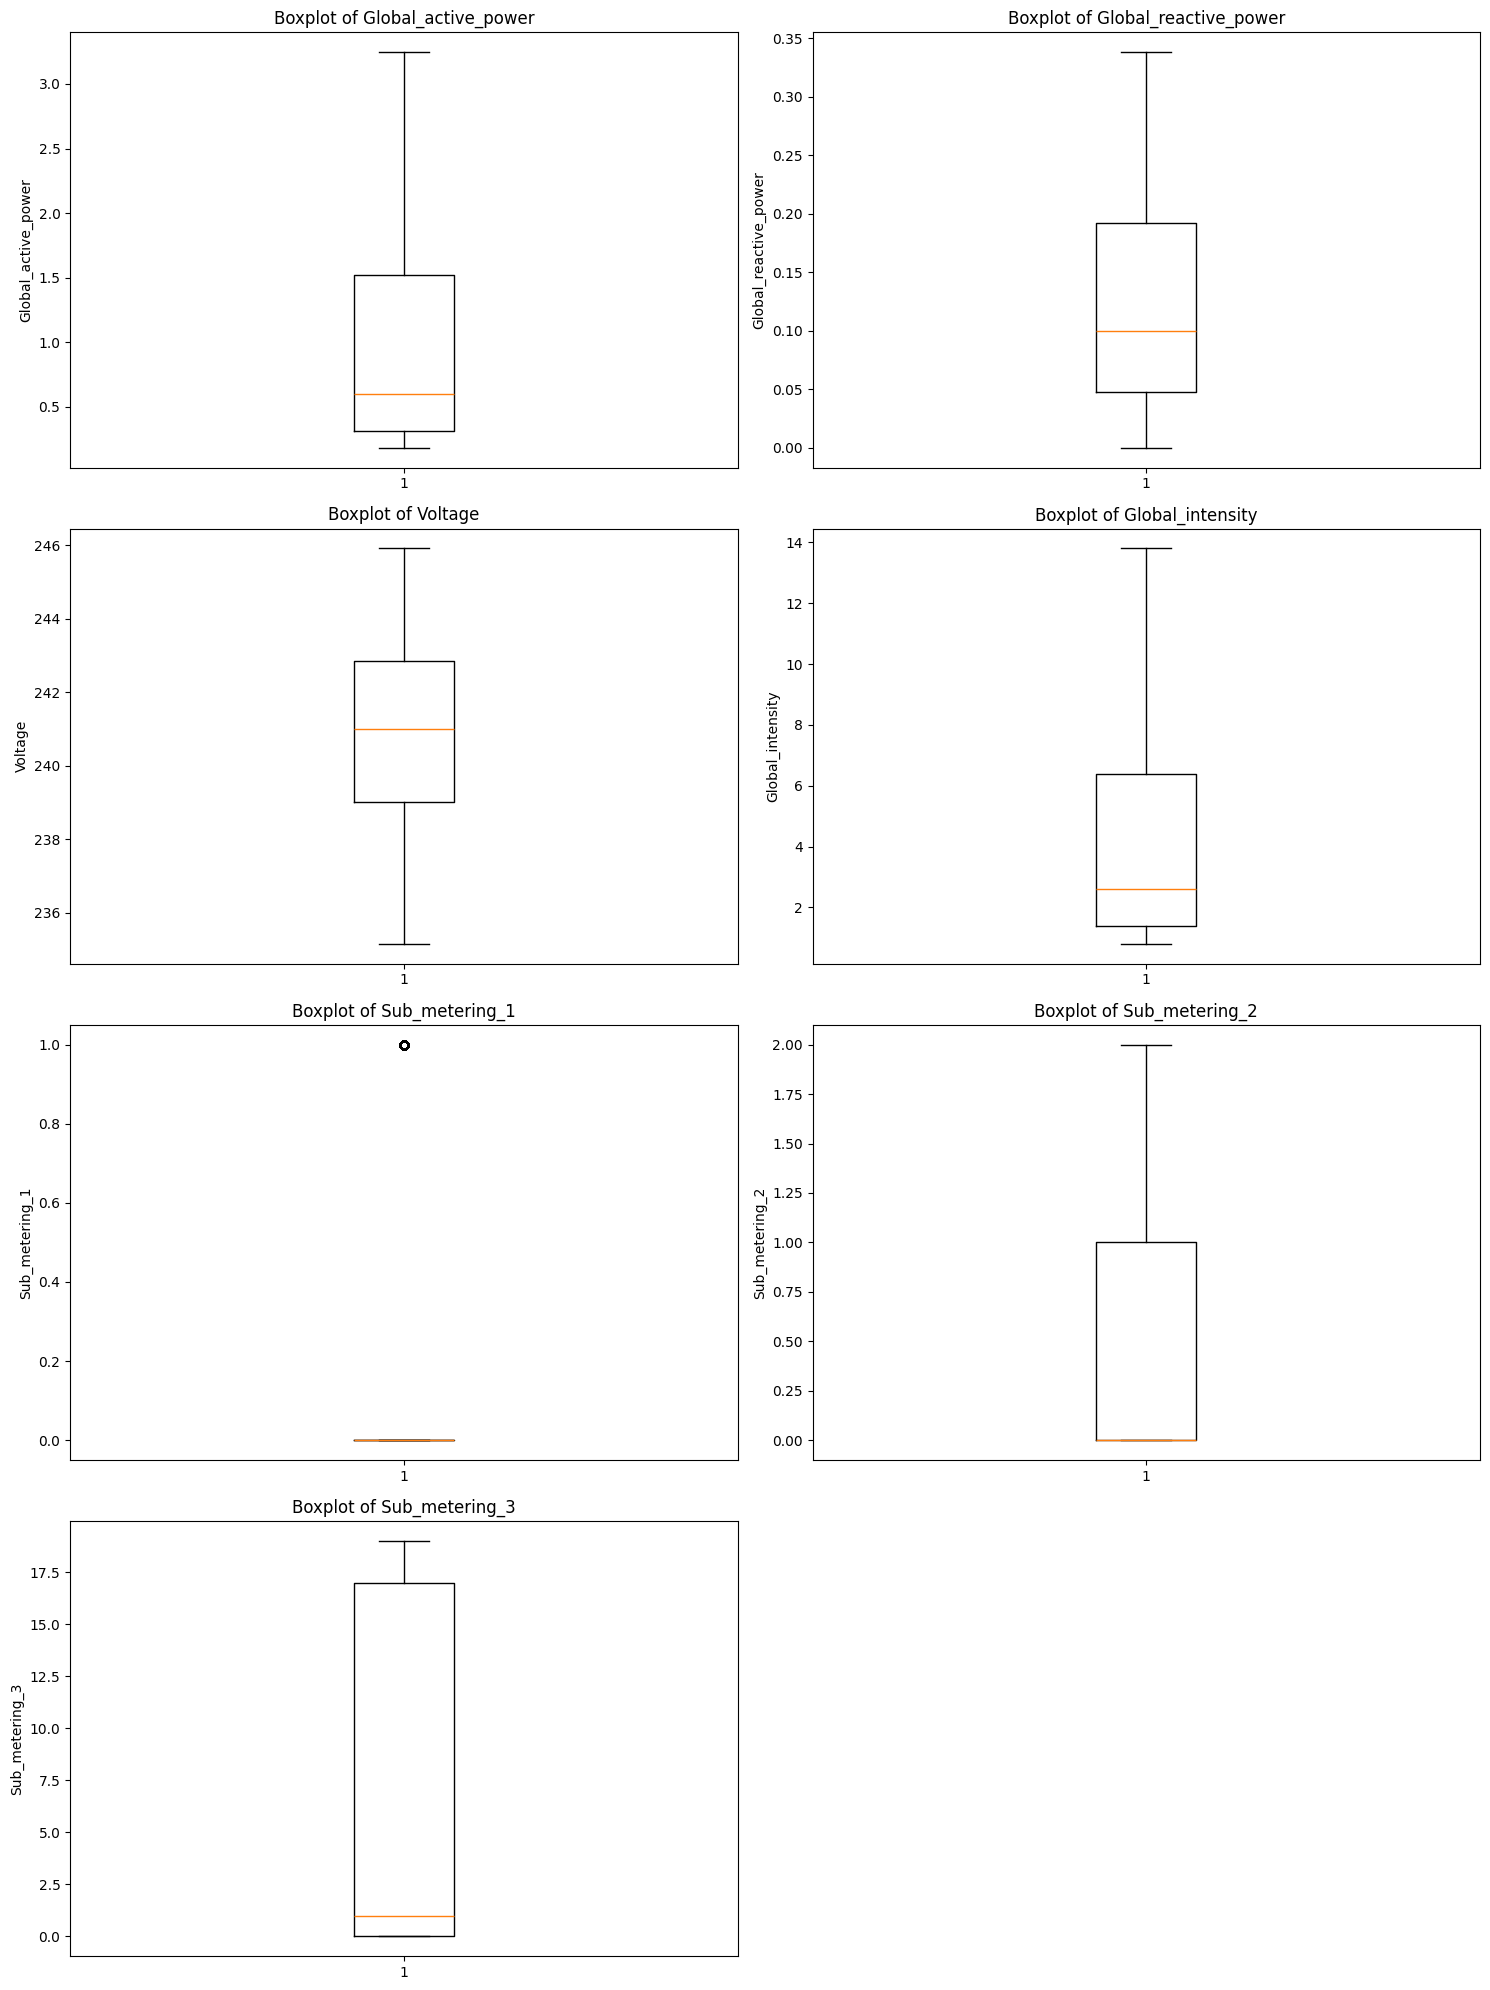

In [115]:

fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.ravel()

for i, col in enumerate(df.select_dtypes(include=['number']).columns):
    axs[i].boxplot(df.select_dtypes(include=['number'])[col].dropna())
    axs[i].set_title(f'Boxplot of {col}')
    axs[i].set_ylabel(col)

if len(df.select_dtypes(include=['number']).columns) < len(axs):
    for j in range(len(df.select_dtypes(include=['number']).columns), len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Distribución de variables

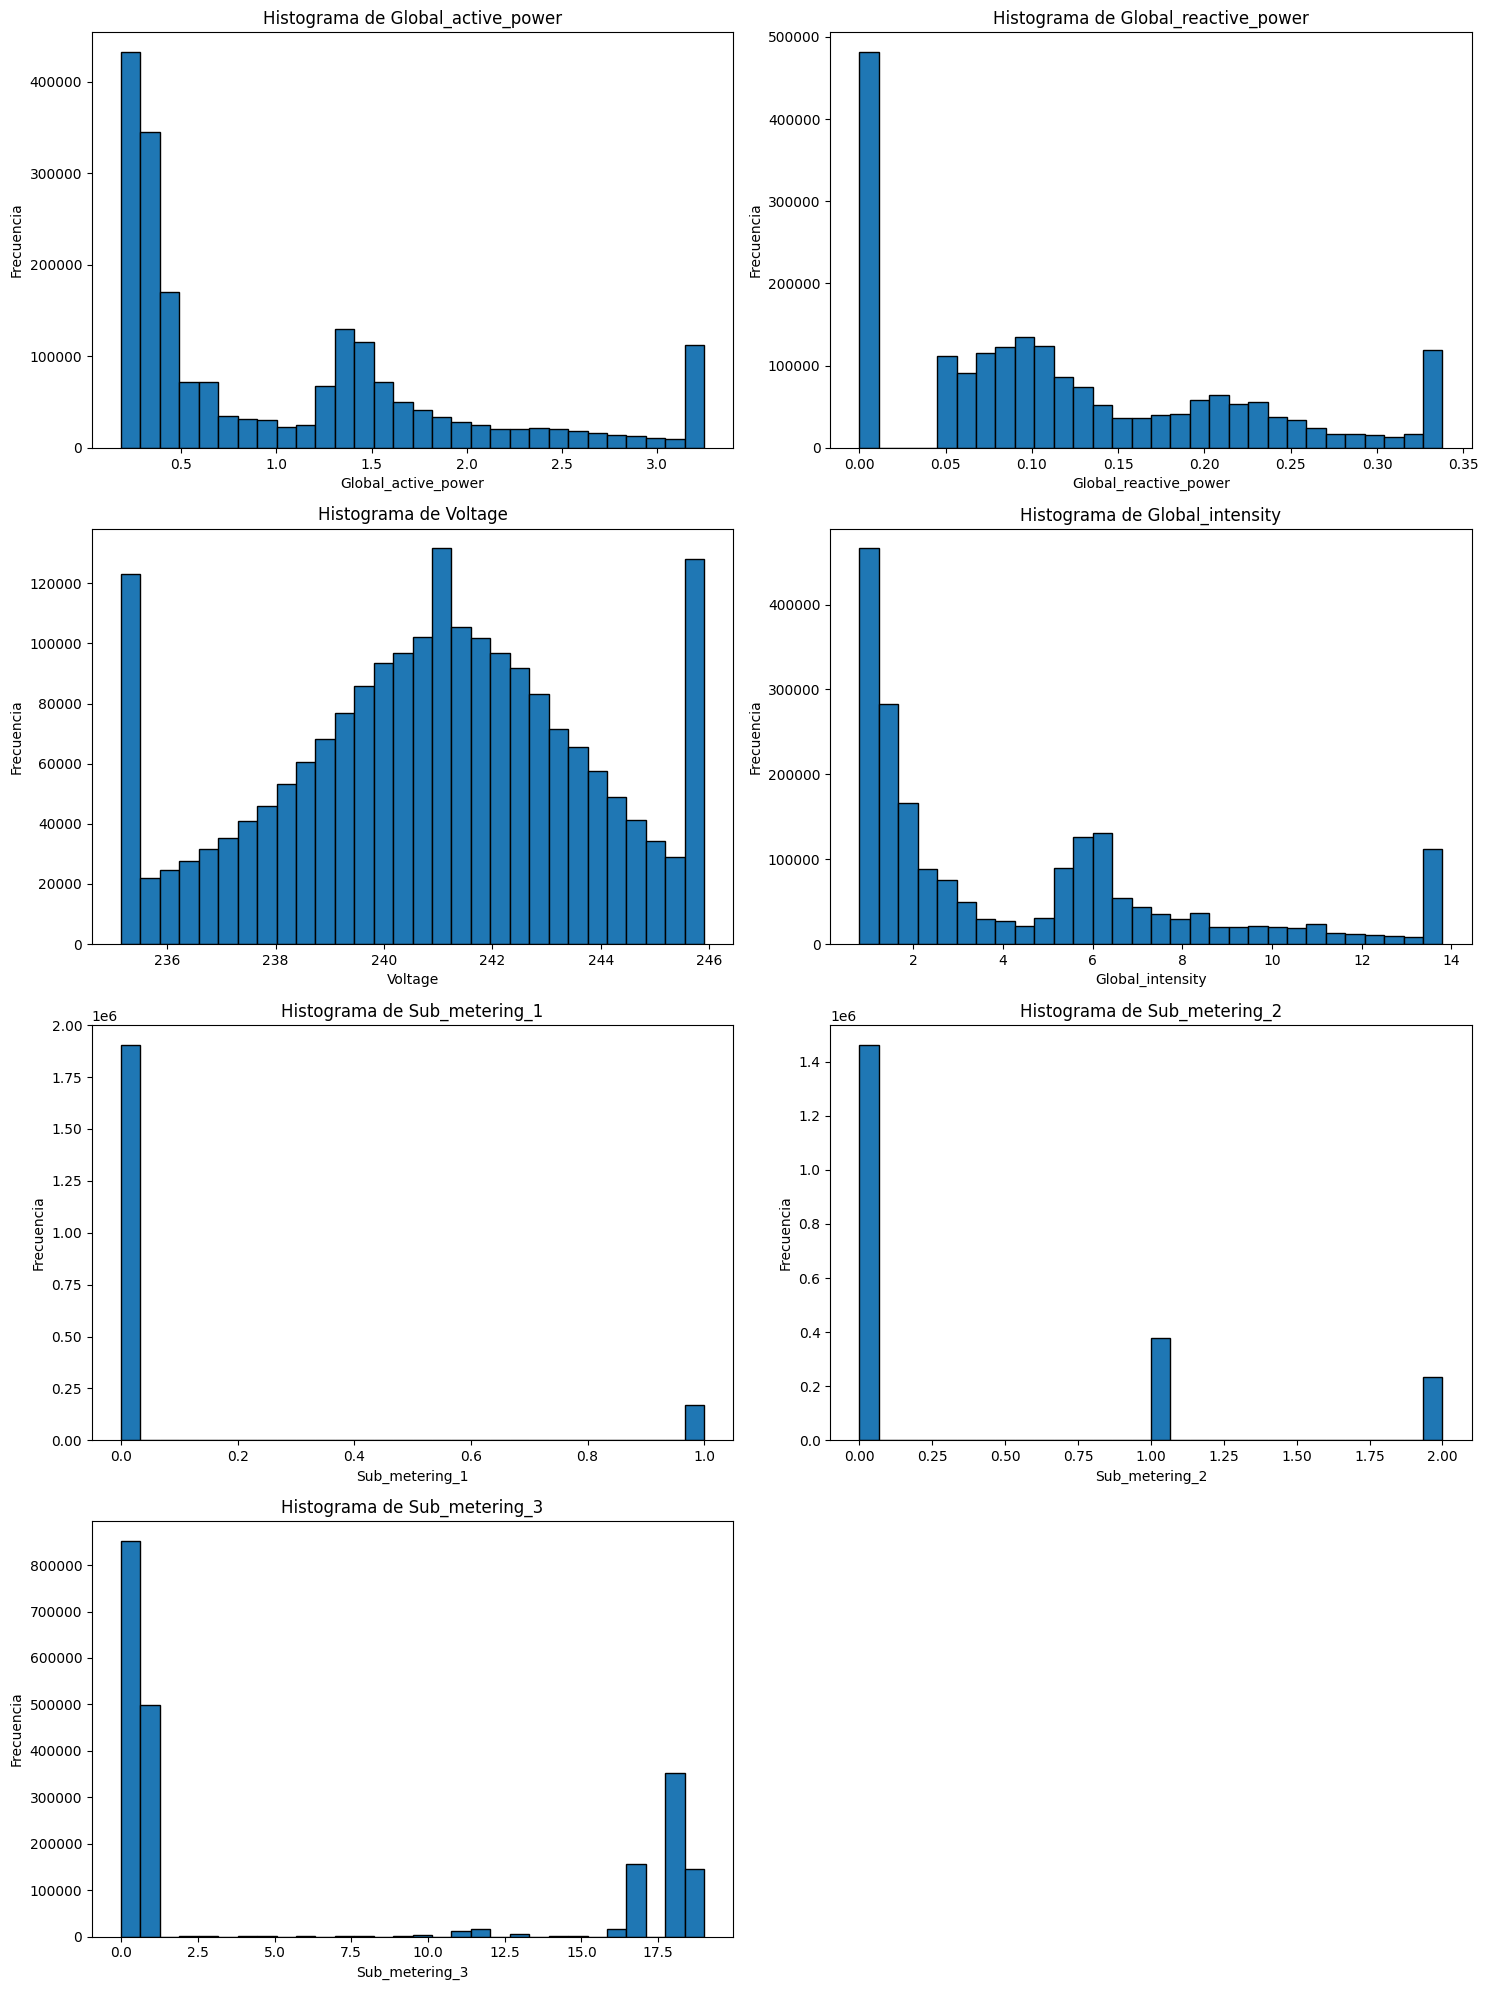

In [116]:
# Crear el layout de subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.ravel()

for i, col in enumerate(df.select_dtypes(include=['number']).columns):
    axs[i].hist(df[col].dropna(), bins=30, edgecolor='black')
    axs[i].set_title(f'Histograma de {col}')
    axs[i].set_ylabel('Frecuencia')
    axs[i].set_xlabel(col)

if len(df.select_dtypes(include=['number']).columns) < len(axs):
    for j in range(len(df.select_dtypes(include=['number']).columns), len(axs)):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

- Global_active_power y Global_reactive_power presentan distribuciones asimétricas hacia la derecha, con una alta concentración de valores bajos y unos pocos valores más altos.
- Voltage tiene una distribución aproximadamente normal, centrada alrededor de 240V, con pocos valores extremos.
- Global_intensity muestra una distribución similar a Global_active_power, indicando una alta frecuencia de valores bajos y unos pocos valores más altos.
- Sub_metering_1 y Sub_metering_2 tienen distribuciones altamente asimétricas, con la mayoría de los valores concentrados en cero y algunos valores puntuales más altos.
- Sub_metering_3 presenta dos picos, uno cerca de cero y otro alrededor de 17.5, sugiriendo dos modos distintos en el consumo de energía medido por este submedidor.

## Correlación de variables

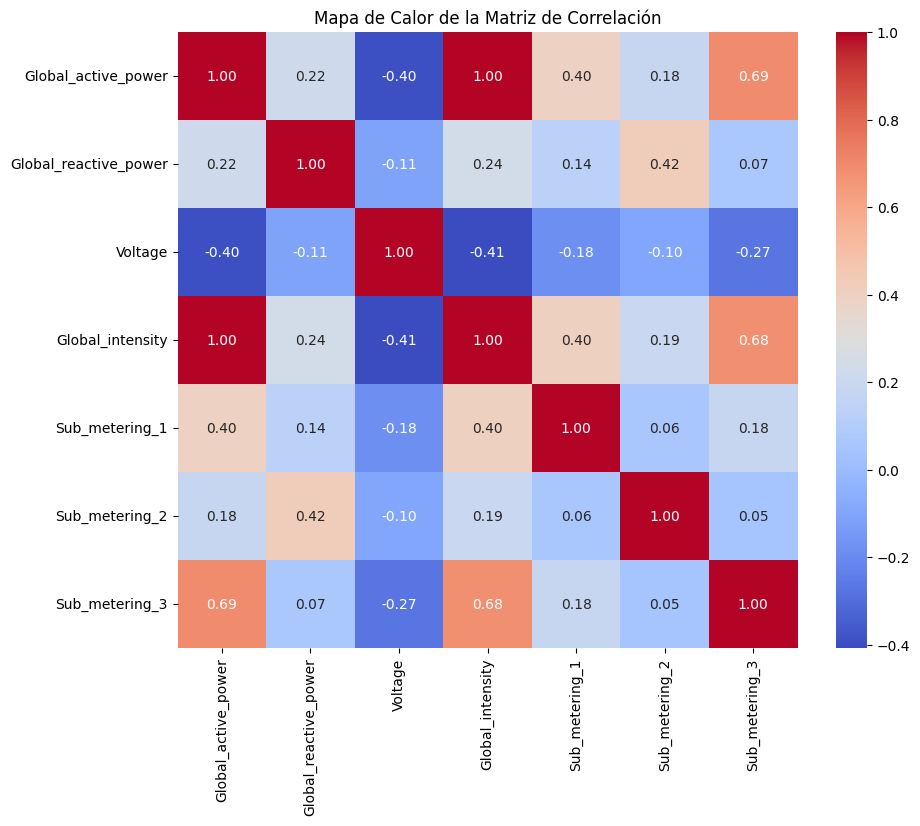

In [117]:
corr_matrix = df.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

- Global_active_power y Global_intensity están altamente correlacionadas positivamente, lo que sugiere que a medida que una aumenta, la otra también lo hace.
- Voltage muestra una relación negativa con varias variables, especialmente con Global_active_power y Global_intensity.
- Sub_metering_3 también tiene una correlación positiva significativa con Global_active_power y Global_intensity, lo que indica que puede estar relacionado con el consumo de energía.

In [118]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,3.25,0.34,235.15,13.80,0.00,1.00,17.00,2006-12-16 17:24:00
1,3.25,0.34,235.15,13.80,0.00,1.00,16.00,2006-12-16 17:25:00
2,3.25,0.34,235.15,13.80,0.00,2.00,17.00,2006-12-16 17:26:00
3,3.25,0.34,235.15,13.80,0.00,1.00,17.00,2006-12-16 17:27:00
4,3.25,0.34,235.68,13.80,0.00,1.00,17.00,2006-12-16 17:28:00


## Descomposición de la serie

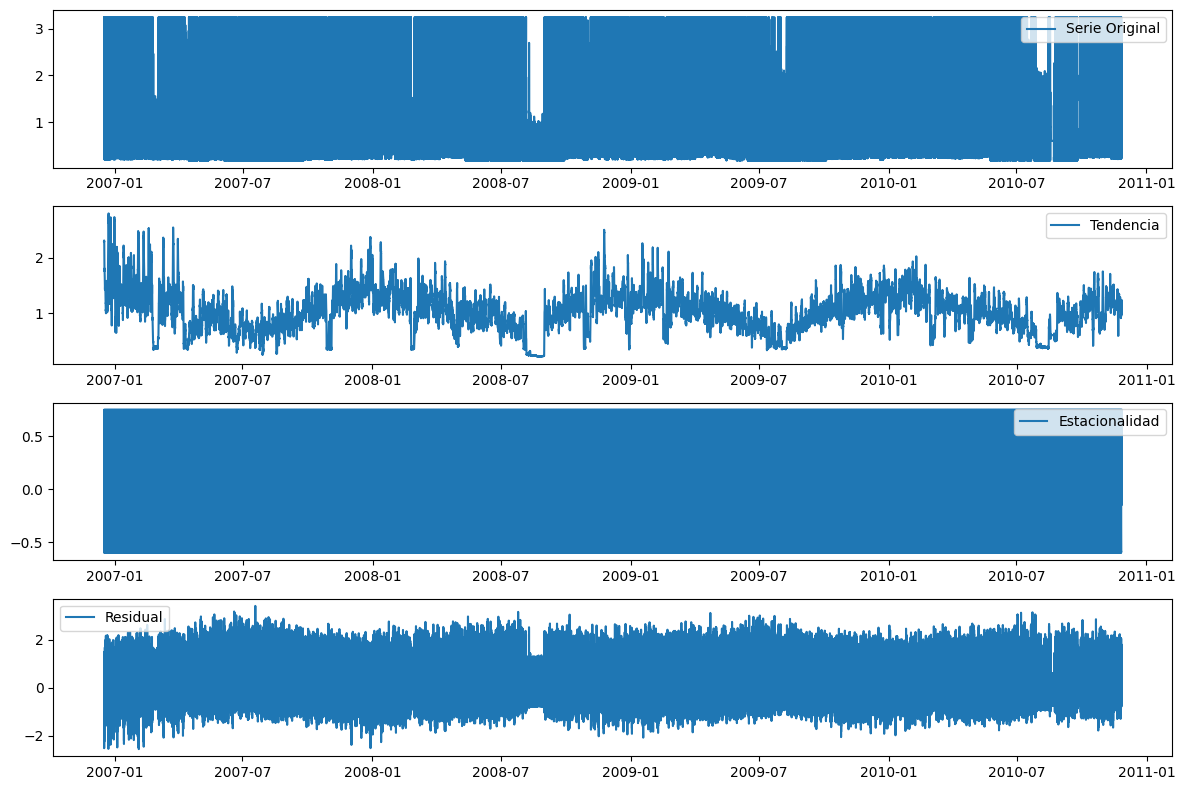

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

series = df['Global_active_power']

# Realizar la descomposición
decomposition = seasonal_decompose(series, model='additive', period=24*60)  # Ajustar 'period' según la frecuencia de tus datos
# Extraer los componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Graficar los componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(series, label='Serie Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

La descomposición de la serie de tiempo Global_active_power, que representa el consumo de electricidad minuto a minuto desde principios de 2007 hasta finales de 2010, muestra varias características clave. La serie original es densa, con muchos datos en cada minuto y picos altos recurrentes que indican patrones de consumo elevados, aunque también presenta caídas abruptas, posiblemente debidas a interrupciones en la recolección de datos o cambios significativos en el consumo. La tendencia revela fluctuaciones a lo largo del tiempo, con picos altos en 2007, una disminución hasta mediados de 2008, y una leve recuperación a partir de 2009 con continuas fluctuaciones hasta 2010. La componente estacional muestra un patrón repetitivo muy denso, con valores variando alrededor de 0.5, aunque la falta de variación visible puede ser causada por la escala de los datos. La componente residual contiene ruido aleatorio y fluctuaciones no explicadas por la tendencia o la estacionalidad, con algunos picos y caídas abruptas similares a la serie original. En conjunto, esta descomposición ayuda a entender mejor los patrones de consumo de electricidad y a identificar posibles anomalías o eventos específicos que afectan el consumo.

# Modelo de pronostico

Con el fin de determinar los posibles valores que el consumo de energia puede llegar a tomar durante los siguientes 60 minutos, se  plantea realizar un modelo de pronostico del consumo de energia a través de un modelo ARIMA. Este tipo de modelos, a pesar de su sencillez, son una buena aproximación metodologica en el pronostico de series de tiempo. 

In [122]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

train_data = series[:-1440]
test_data = series[-1440:]

model = ARIMA(train_data, order=(5, 1, 0))  #Valores asignados arbitrariamente, se recomienda hacer stepwise con Akaike para determinar el orden optimo.
model_fit = model.fit()

# Realizar predicciones
forecast = model_fit.forecast(steps=60)


forecast_index = pd.date_range(start=series.index[-1], periods=61, freq='T')[1:]
forecast_df = pd.DataFrame({'Datetime': forecast_index, 'Forecast': forecast})
forecast_df.set_index('Datetime', inplace=True)

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_13/726698352.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_index = pd.date_range(start=series.index[-1], periods=61, freq='T')[1:]  # Crear un índice de tiempo para las predicciones


In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(test_data[:60], forecast)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.18515399445480998


In [ ]:
import plotly.express as px
fig = px.line()

fig.add_scatter(x=series.index, y=series, mode='lines', name='Serie Original')

fig.add_scatter(x=forecast_df.index, y=forecast_df['Forecast'], mode='lines', name='Pronóstico', line=dict(color='red'))

fig.update_layout(title='Pronóstico del Consumo de Electricidad',
                  xaxis_title='Tiempo',
                  yaxis_title='Consumo de Electricidad (kW)',
                  legend_title='Series')

fig.show()